In [1]:
c = 299792458
#from direction_rotate import _calc_rotation_mats
import matplotlib.pyplot as plt
import xarray as xr
import dask.array as da
import cngi.conversion.convert_ms as convert_ms
import cngi.conversion.convert_image as convert_image
from cngi.dio import read_vis
import numpy as np
from astropy.coordinates import SkyCoord
from sirius import calc_vis_point, calc_vis
from sympy import *
from astropy.wcs import WCS
import time

In [2]:
from sirius import calc_uvw
from astropy.time import Time

In [3]:
#Load Data from converted CASA simulated ms (steal uvw values)
ms_file = 'point_source_sim_vis/mosaic_point_source_sim_dovp_True.vis.zarr' #remember to change pb_parms['pb_func'] = 'casa_airy'
#ms_file = 'point_source_sim_vis/point_source_sim_dovp_False.vis.zarr'
#remember to change pb_parms['pb_func'] = 'none'
#ms_file = 'zenith_point_source_sim_dovp_False.vis.zarr'

In [4]:
mxds = read_vis(ms_file)
print(mxds)

<xarray.Dataset>
Dimensions:           (antenna_ids: 3, feed_ids: 3, field_ids: 2, observation_ids: 1, polarization_ids: 1, source_ids: 2, spw_ids: 1, state_ids: 1)
Coordinates:
  * antenna_ids       (antenna_ids) int64 0 1 2
    antennas          (antenna_ids) <U16 'W01' 'W02' 'W03'
  * field_ids         (field_ids) int64 0 1
    fields            (field_ids) <U5 'fake' 'fake2'
  * feed_ids          (feed_ids) int64 0 0 0
  * observation_ids   (observation_ids) int64 0
    observations      (observation_ids) <U16 'CASA simulation'
  * polarization_ids  (polarization_ids) int64 0
  * source_ids        (source_ids) int64 0 1
    sources           (source_ids) <U5 'fake' 'fake2'
  * spw_ids           (spw_ids) int64 0
  * state_ids         (state_ids) int64 0
Data variables:
    *empty*
Attributes:
    xds0:             <xarray.Dataset>\nDimensions:                (baseline:...
    ANTENNA:          <xarray.Dataset>\nDimensions:        (antenna_id: 3, d1...
    FEED:             <xarray.

In [5]:
vis_xds = read_vis(ms_file).xds0

In [6]:
cas_vis_data = vis_xds.DATA.data.compute()

In [7]:
uvw = vis_xds.UVW.data.compute()

In [8]:
freq_chan = vis_xds.chan.values

In [9]:
cas_vis_data.shape

(10, 3, 3, 2)

### Create UVWs

In [10]:
mxds.ANTENNA

<xarray.Dataset>
Dimensions:        (antenna_id: 3, d1: 3)
Coordinates:
  * antenna_id     (antenna_id) int64 0 1 2
Dimensions without coordinates: d1
Data variables:
    DISH_DIAMETER  (antenna_id) float64 dask.array<chunksize=(3,), meta=np.ndarray>
    MOUNT          (antenna_id) <U16 dask.array<chunksize=(3,), meta=np.ndarray>
    NAME           (antenna_id) <U16 dask.array<chunksize=(3,), meta=np.ndarray>
    OFFSET         (antenna_id, d1) float64 dask.array<chunksize=(3, 3), meta=np.ndarray>
    POSITION       (antenna_id, d1) float64 dask.array<chunksize=(3, 3), meta=np.ndarray>
    STATION        (antenna_id) <U16 dask.array<chunksize=(3,), meta=np.ndarray>
    TYPE           (antenna_id) <U16 dask.array<chunksize=(3,), meta=np.ndarray>

In [11]:
vis_xds.time

<xarray.DataArray 'time' (time: 10)>
array(['2019-10-03T22:25:38.491905280', '2019-10-03T23:25:38.491905280',
       '2019-10-04T00:25:38.491905280', '2019-10-04T01:25:38.491905280',
       '2019-10-04T02:25:38.491905280', '2019-10-04T03:25:38.491905280',
       '2019-10-04T04:25:38.491905280', '2019-10-04T05:25:38.491905280',
       '2019-10-04T06:25:38.491905280', '2019-10-04T07:25:38.491905280'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2019-10-03T22:25:38.491905280 ... 2019-10-...

In [12]:
use_user_pointing = True
#user_pointing_direction = [[2.8879233,  np.pi/2]] #ra dec in radians
phase_center = SkyCoord(ra='20h00m28.5s',dec='+40d44m01.5s',frame='fk5') #sim
user_pointing_direction = [[phase_center.ra.rad, phase_center.dec.rad]]
#ant_pos = global_dataset.ANT_POSITION.data.compute() #n_ant x 3
ant_pos = mxds.ANTENNA.POSITION.values
site = 'alma'
time_indx = 0 #The uvw coordinates are only calculated for a single time step.
#fields = vis_xds.time.field_id[time_indx:time_indx+1].data.compute()
#pointing_direction = global_dataset.FIELD_PHASE_DIR[fields,:,0].data.compute() 

if use_user_pointing:
    pointing_direction = np.array(user_pointing_direction)

time_obj = Time(vis_xds.time.data[time_indx], scale='utc')
mjd = np.ascontiguousarray(time_obj.mjd)

In [13]:
#Antenna uvw: astropy
uvw_astropy = calc_uvw.calc_uvw_astropy(ant_pos, mjd, site, pointing_direction)


In [14]:
time_obj = Time(vis_xds.time.data[time_indx:time_indx+2], scale='utc')
mjd = np.ascontiguousarray(time_obj.mjd)
len(mjd)

2

In [15]:
#CALC11 wrapped code needs at least two time steps otherwise it returns nan 
#(the calculations are independent, the issue has to do with singleton dimensions). 
#The second time step is ignored in calc_uvw_CALC.
#fields = vis_xds.time.field_id[time_indx:time_indx+2].data.compute()
#pointing_direction = global_dataset.FIELD_PHASE_DIR[fields,:,0].data.compute() 
time_obj = Time(vis_xds.time.data[time_indx:time_indx+2], scale='utc')
mjd = np.ascontiguousarray(time_obj.mjd)
if use_user_pointing:
    pointing_direction = np.array([user_pointing_direction[0]]*len(mjd))

endian_path = "/users/mbarth/sirius/development/DE421_little_Endian"
uvw_CALC = calc_uvw.calc_uvw_CALC(endian_path, ant_pos, mjd, pointing_direction,time_obj,delta = 0.00001)


[-4871503.43641193 -4871537.66353539 -4871570.80320378]


In [16]:
uvw_CALC

array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])

In [62]:
len(mjd)

2

In [61]:
time_obj

<Time object: scale='utc' format='datetime64' value=['2019-10-03T22:25:38.491905280' '2019-10-03T23:25:38.491905280']>

In [21]:
vis_xds

<xarray.Dataset>
Dimensions:                (baseline: 3, chan: 3, pol: 2, pol_id: 1, spw_id: 1, time: 10, uvw_index: 3)
Coordinates:
  * baseline               (baseline) int64 0 1 2
  * chan                   (chan) float64 3e+09 3.4e+09 3.8e+09
    chan_width             (chan) float64 dask.array<chunksize=(3,), meta=np.ndarray>
    effective_bw           (chan) float64 dask.array<chunksize=(3,), meta=np.ndarray>
  * pol                    (pol) int64 5 8
  * pol_id                 (pol_id) int64 0
    resolution             (chan) float64 dask.array<chunksize=(3,), meta=np.ndarray>
  * spw_id                 (spw_id) int64 0
  * time                   (time) datetime64[ns] 2019-10-03T22:25:38.49190528...
Dimensions without coordinates: uvw_index
Data variables: (12/20)
    ANTENNA1               (baseline) int64 dask.array<chunksize=(3,), meta=np.ndarray>
    ANTENNA2               (baseline) int64 dask.array<chunksize=(3,), meta=np.ndarray>
    ARRAY_ID               (time, baseline) int64 dask.array<chunksize=(10, 3), meta=np.ndarray>
    CORRECTED_DATA         (time, baseline, chan, pol) complex128 dask.array<chunksize=(10, 3, 3, 1), meta=np.ndarray>
    CORRECTED_DATA_WEIGHT  (time, baseline, chan, pol) float64 dask.array<chunksize=(10, 3, 3, 1), meta=np.ndarray>
    DATA                   (time, baseline, chan, pol) complex128 dask.array<chunksize=(10, 3, 3, 1), meta=np.ndarray>
    ...                     ...
    OBSERVATION_ID         (time, baseline) int64 dask.array<chunksize=(10, 3), meta=np.ndarray>
    PROCESSOR_ID           (time, baseline) int64 dask.array<chunksize=(10, 3), meta=np.ndarray>
    SCAN_NUMBER            (time, baseline) int64 dask.array<chunksize=(10, 3), meta=np.ndarray>
    STATE_ID               (time, baseline) int64 dask.array<chunksize=(10, 3), meta=np.ndarray>
    TIME_CENTROID          (time, baseline) float64 dask.array<chunksize=(10, 3), meta=np.ndarray>
    UVW                    (time, baseline, uvw_index) float64 dask.array<chunksize=(10, 3, 3), meta=np.ndarray>
Attributes:
    corr_product:     [[0, 0], [1, 1]]
    data_groups:      [{'0': {'data': 'DATA', 'flag': 'FLAG', 'id': '0', 'uvw...
    freq_group:       0
    freq_group_name:  Group 1
    if_conv_chain:    0
    meas_freq_ref:    1
    name:             SBand
    net_sideband:     1
    num_chan:         3
    num_corr:         2
    ref_frequency:    3000000000.0
    total_bandwidth:  1200000000.0

In [23]:
vis_xds.ANTENNA1

<xarray.DataArray 'ANTENNA1' (baseline: 3)>
dask.array<open_dataset-4279de9749b50486cdb8849d4eff6974ANTENNA1, shape=(3,), dtype=int64, chunksize=(3,), chunktype=numpy.ndarray>
Coordinates:
  * baseline  (baseline) int64 0 1 2

In [25]:
vis_xds.ANTENNA1.values

array([0, 0, 1])

In [29]:
vis_xds.UVW[time_indx,:,:].values

array([[ 17.60104606, -38.54720788,   8.57567532],
       [ 24.19015155, -56.15432729,  49.51498369],
       [  6.5891055 , -17.60711941,  40.93930837]])

In [39]:
uvw_baseline_casa

array([[[ -7.6161063 ,  -3.69038618,   4.29508277],
        [-18.41960345,  -5.74197319,   6.69899547],
        [-10.80349715,  -2.05158701,   2.4039127 ]],

       [[-13.50174417,  -8.5474191 ,   9.93779789],
        [-33.91847754, -14.41300879,  16.78495054],
        [-20.41673337,  -5.86558969,   6.84715265]],

       [[ -5.88563787,  -4.85703292,   5.64271512],
        [-15.49887409,  -8.6710356 ,  10.08595507],
        [ -9.61323622,  -3.81400268,   4.44323995]]])

In [40]:
uvw_astropy.shape

(3, 3)

In [41]:
uvw_CALC.shape

(3, 3)

In [43]:
uvw[0][vis_xds.ANTENNA1.values]

array([[ 17.60104606, -38.54720788,   8.57567532],
       [ 17.60104606, -38.54720788,   8.57567532],
       [ 24.19015155, -56.15432729,  49.51498369]])

In [47]:
uvw_baseline_astropy

array([[ 17.59968457, -38.54778189,   8.57588939],
       [ 24.18776664, -56.15509349,  49.5152798 ],
       [  6.58808207, -17.6073116 ,  40.93939042]])

In [48]:
uvw_baseline_casa

array([[ -6.5891055 ,  17.60711941, -40.93930837],
       [ 11.01194056, -20.94008847, -32.36363305],
       [ 17.60104606, -38.54720788,   8.57567532]])

In [50]:
uvw_CALC

array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])

Text(0.5, 1.0, 'w Coord')

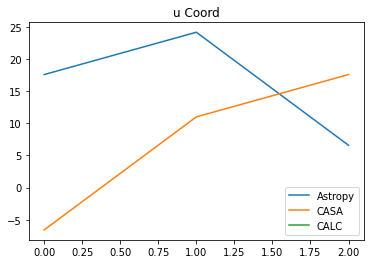

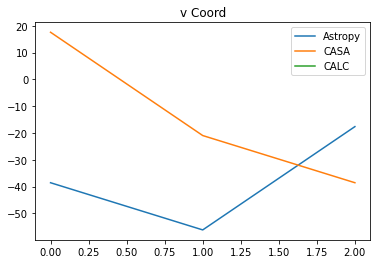

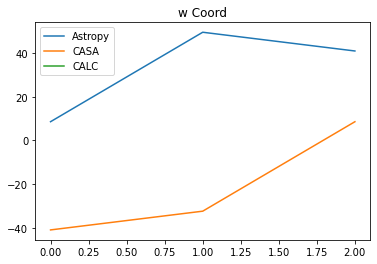

In [46]:
#Baseline uvw
uvw_baseline_astropy = uvw_astropy[vis_xds.ANTENNA1.values] - uvw_astropy[vis_xds.ANTENNA2.values]
uvw_baseline_casa = uvw[0][vis_xds.ANTENNA1.values] - uvw[0][vis_xds.ANTENNA2.values]
uvw_baseline_CALC = - uvw_CALC[vis_xds.ANTENNA1.values] + uvw_CALC[vis_xds.ANTENNA2.values]

dif1 = (vis_xds.UVW[time_indx,:,:].values - uvw_baseline_astropy)
dif2 = (vis_xds.UVW[time_indx,:,:].values - uvw_baseline_casa)
dif3 = (vis_xds.UVW[time_indx,:,:].values - uvw_baseline_CALC)  
dif4 = (uvw_baseline_astropy - uvw_baseline_casa)
dif5 = (uvw_baseline_casa - uvw_baseline_CALC)
dif6 = (uvw_baseline_astropy - uvw_baseline_CALC)

dif1_per = 100*(vis_xds.UVW[time_indx,:,:].values - uvw_baseline_astropy)/vis_xds.UVW[time_indx,:,:].values  
dif2_per = 100*(vis_xds.UVW[time_indx,:,:].values - uvw_baseline_casa)/vis_xds.UVW[time_indx,:,:]
dif3_per = 100*(vis_xds.UVW[time_indx,:,:].values - uvw_baseline_CALC)/vis_xds.UVW[time_indx,:,:]  
dif4_per = 100*(uvw_baseline_astropy - uvw_baseline_casa)/uvw_baseline_casa
dif5_per = 100*(uvw_baseline_casa - uvw_baseline_CALC)/uvw_baseline_casa   
dif6_per = 100*(uvw_baseline_astropy - uvw_baseline_CALC)/uvw_baseline_casa

plt.figure()
plt.plot(uvw_baseline_astropy[:,0])
plt.plot(uvw_baseline_casa[:,0])
plt.plot(uvw_baseline_CALC[:,0])
if use_user_pointing:
    plt.legend(['Astropy', 'CASA', 'CALC'])
else: 
    plt.plot(vis_xds.UVW[time_indx,:,0].values)
    plt.legend(['Astropy', 'CASA', 'CALC', 'MS'])
plt.title('u Coord')

plt.figure()
plt.plot(uvw_baseline_astropy[:,1])
plt.plot(uvw_baseline_casa[:,1])
plt.plot(uvw_baseline_CALC[:,1])
if use_user_pointing:
    plt.legend(['Astropy', 'CASA', 'CALC'])
else: 
    plt.plot(vis_xds.UVW[time_indx,:,1].values)
    plt.legend(['Astropy', 'CASA', 'CALC', 'MS'])
plt.title('v Coord')


plt.figure()
plt.plot(uvw_baseline_astropy[:,2])
plt.plot(uvw_baseline_casa[:,2])
plt.plot(uvw_baseline_CALC[:,2])
if use_user_pointing:
    plt.legend(['Astropy', 'CASA', 'CALC'])
else: 
    plt.plot(vis_xds.UVW[time_indx,:,2].values)
    plt.legend(['Astropy', 'CASA', 'CALC', 'MS'])
plt.title('w Coord')

### Sirius Simulation

In [16]:
#Setup phase centre (rename pointing_ra_dec to phase_center)
#pointing_ra_dec:  [n_time, 2]                   (singleton: n_time, n_baseline)
phase_center = SkyCoord(ra='20h00m28.5s',dec='+40d44m01.5s',frame='fk5') #sim
phase_center2 = SkyCoord(ra='19h58m28.5s',dec='+40d44m01.5s',frame='fk5')
#To do: concat, check shape
#pointing_skycoord = SkyCoord(ra='0h0m0.0s',dec='90d00m00.0s',frame='fk5') #zenith
phase_center_ra_dec = np.array([phase_center.ra.rad,phase_center.dec.rad]).reshape((1, 2))*np.ones(5).reshape((5, 1))
phase_center_ra_dec2 = np.array([phase_center2.ra.rad,phase_center2.dec.rad]).reshape((1, 2))*np.ones(5).reshape((5, 1))
phase_center_ra_dec = np.append(phase_center_ra_dec, phase_center_ra_dec2, axis = 0)

In [11]:
old_pointing_ra_dec = phase_center_ra_dec.reshape((10, 1, 2))#*np.ones((1, 3, 1))

In [12]:
phase_center_ra_dec[5]

array([5.22933369, 0.71093805])

In [13]:
old_pointing_ra_dec

array([[[5.23806033, 0.71093805]],

       [[5.23806033, 0.71093805]],

       [[5.23806033, 0.71093805]],

       [[5.23806033, 0.71093805]],

       [[5.23806033, 0.71093805]],

       [[5.22933369, 0.71093805]],

       [[5.22933369, 0.71093805]],

       [[5.22933369, 0.71093805]],

       [[5.22933369, 0.71093805]],

       [[5.22933369, 0.71093805]]])

In [14]:
#Pointing_ra_dec
pointing_ra_dec = np.zeros((1, 1, 2)) #Singleton

In [15]:
#Setup point source skycoord
#point_source_ra_dec:  [n_time, n_point_sources, 2]          (singleton: n_time)
point_source_skycoord = SkyCoord(ra='20h00m28.5s',dec='+40d44m01.5s',frame='fk5') #sim
point_source_skycoord2 = SkyCoord(ra='19h58m28.5s',dec='+40d44m01.5s',frame='fk5') #sim
#point_source_skycoord = SkyCoord(ra='19h59m0.0s',dec='+89d54m01.5s',frame='fk5') #zenith
point_source_ra_dec = np.array([point_source_skycoord.ra.rad,point_source_skycoord.dec.rad])[None,None,:]*np.ones(10).reshape(10, 1, 1)
point_source_ra_dec2 = np.array([point_source_skycoord2.ra.rad,point_source_skycoord2.dec.rad])[None,None,:]*np.ones(10).reshape(10, 1, 1)
point_source_ra_dec = np.append(point_source_ra_dec, point_source_ra_dec2, axis = 1)

In [16]:
point_source_ra_dec[:, 1]

array([[5.22933369, 0.71093805],
       [5.22933369, 0.71093805],
       [5.22933369, 0.71093805],
       [5.22933369, 0.71093805],
       [5.22933369, 0.71093805],
       [5.22933369, 0.71093805],
       [5.22933369, 0.71093805],
       [5.22933369, 0.71093805],
       [5.22933369, 0.71093805],
       [5.22933369, 0.71093805]])

In [17]:
point_source_ra_dec[0]

array([[5.23806033, 0.71093805],
       [5.22933369, 0.71093805]])

In [18]:
#Source flux
#point_source_flux: [n_time, n_chan, n_pol, n_point_sources] (singleton: n_time, n_chan, n_pol)
point_source_flux = np.array([2.17, 2.17])[None,None,None,:]*np.ones(10).reshape(10, 1, 1, 1)

In [19]:
point_source_flux.shape

(10, 1, 1, 2)

In [20]:
#Primary Beam Model parameters
pb_parms = {}
pb_parms['pb_func'] = 'casa_airy' # casa_airy/airy/none
#pb_parms['pb_func'] = 'none'
pb_parms['dish_diameter'] = 24.5
pb_parms['blockage_diameter'] = 0.0
pb_parms['ipower'] = 1 #CHANGE

In [21]:
n_time, n_baseline, n_chan, n_pol = cas_vis_data.shape
antenna1 = np.zeros(n_baseline)
antenna2 = np.zeros(n_baseline)
n_ant = 1

In [22]:
phase_center_ra_dec.shape

(10, 2)

In [23]:
start = time.time()
vis_data = calc_vis_point.calc_vis(uvw,cas_vis_data.shape,point_source_flux,point_source_ra_dec,pointing_ra_dec,phase_center_ra_dec,antenna1,antenna2,n_ant,freq_chan,pb_parms)
print('Compute Time', time.time()-start)

Compute Time 0.031206846237182617


In [24]:
start = time.time()
vis_data_test = calc_vis(uvw, cas_vis_data.shape,point_source_flux,point_source_ra_dec,old_pointing_ra_dec,freq_chan,pb_parms)
print('Compute Time', time.time()-start)

Compute Time 0.02929830551147461


In [25]:
abs_dif = np.ravel(np.abs(vis_data_test[:,:,:,0]-vis_data[:,:,:,0])/np.abs(vis_data[:,:,:,0]))

Text(0, 0.5, 'Relative Change (out of 1)')

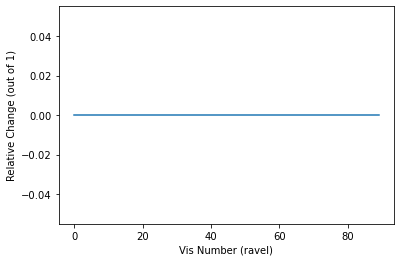

In [26]:
plt.figure()
plt.plot(abs_dif)
plt.xlabel('Vis Number (ravel)')
plt.ylabel('Relative Change (out of 1)')

In [27]:
abs_dif = np.ravel(np.abs(cas_vis_data[:,:,:,0]-vis_data[:,:,:,0])/np.abs(vis_data[:,:,:,0]))

In [28]:
cas_vis_data.shape

(10, 3, 3, 2)

In [29]:
vis_data.shape

(10, 3, 3, 2)

Text(0, 0.5, 'Relative Change (out of 1)')

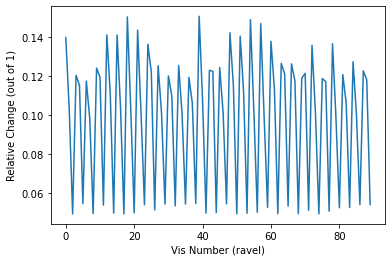

In [30]:
plt.figure()
plt.plot(abs_dif)
plt.xlabel('Vis Number (ravel)')
plt.ylabel('Relative Change (out of 1)')

### Create Image Using ngCASA

In [31]:
#from cngi.vis import apply_flags
from ngcasa.imaging import make_imaging_weight
from ngcasa.imaging import make_image
from ngcasa.imaging import make_pb
from ngcasa.imaging import make_gridding_convolution_function
from cngi.dio import write_image
import dask
import dask.array as da

In [32]:
rad_to_deg =  180/np.pi
deg_to_rad = np.pi/180
arcsec_to_deg = 1/3600
arcsec_to_rad = np.pi/(180*3600)

In [33]:
#mxds = apply_flags(mxds, 'xds0', flags='FLAG')
mxds.attrs['xds1'] = mxds.attrs['xds0'].isel(pol=slice(0,1))
mxds.attrs['xds1']['DATA'] = xr.DataArray(da.from_array(vis_data[:,:,:,0][:,:,:,None],chunks=mxds.attrs['xds1']['DATA'].chunks),coords=mxds.attrs['xds1']['DATA'].coords)

In [34]:
from ngcasa.imaging import direction_rotate
xr.set_options(display_style="html")

In [35]:
grid_parms = {}
grid_parms['chan_mode'] = 'cube'
grid_parms['image_size'] = [800,400]
grid_parms['cell_size'] = [5,5]
grid_parms['phase_center'] = (mxds.FIELD.PHASE_DIR[0,0,:].data.compute() + mxds.FIELD.PHASE_DIR[1,0,:].data.compute())/2

In [36]:
mxds.xds1.data_groups

[{'0': {'data': 'DATA',
   'flag': 'FLAG',
   'id': '0',
   'uvw': 'UVW',
   'weight': 'DATA_WEIGHT'},
  '1': {'data': 'CORRECTED_DATA',
   'flag': 'FLAG',
   'id': '1',
   'uvw': 'UVW',
   'weight': 'CORRECTED_DATA_WEIGHT'}}]

In [37]:
sel_parms = {}
sel_parms['xds'] = 'xds1' #KEEP USING XDS1 THROUGHOUT
sel_parms['data_group_in_id'] = 0 #CHANGE TO DATA GROUP 2 AFTER ROTATION

rotation_parms = {}
rotation_parms['new_phase_center'] = grid_parms['phase_center']
rotation_parms['common_tangent_reprojection'] = True
rotation_parms['single_precision'] = False

mxds = direction_rotate(mxds, rotation_parms, sel_parms)

######################### Start direction_rotate #########################
Setting data_group_in  to  {'data': 'DATA', 'flag': 'FLAG', 'id': '0', 'uvw': 'UVW', 'weight': 'DATA_WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '2', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT'}
######################### Created graph for direction_rotate #########################


In [38]:
mxds.xds1.data_groups

[{'0': {'data': 'DATA',
   'flag': 'FLAG',
   'id': '0',
   'uvw': 'UVW',
   'weight': 'DATA_WEIGHT'},
  '1': {'data': 'CORRECTED_DATA',
   'flag': 'FLAG',
   'id': '1',
   'uvw': 'UVW',
   'weight': 'CORRECTED_DATA_WEIGHT'},
  '2': {'data': 'DATA_ROT',
   'flag': 'FLAG',
   'id': '2',
   'uvw': 'UVW_ROT',
   'weight': 'DATA_WEIGHT'}}]

In [39]:
imaging_weights_parms = {}
imaging_weights_parms['weighting'] = 'natural'

In [40]:
sel_parms = {}
sel_parms['xds'] = 'xds1'
sel_parms['data_group_in_id'] = 2

In [41]:
mxds = make_imaging_weight(mxds, imaging_weights_parms, grid_parms, sel_parms)

######################### Start make_imaging_weights #########################
Setting data_group_in  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '2', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '2', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'IMAGING_WEIGHT'}
Since weighting is natural input weight will be reused as imaging weight.
######################### Created graph for make_imaging_weight #########################


In [42]:
vis_sel_parms = {}
vis_sel_parms['xds'] = 'xds1'
vis_sel_parms['data_group_in_id'] = 2

In [43]:
img_sel_parms = {}
img_sel_parms['data_group_out_id'] = 0

In [44]:
from cngi.dio import write_image
write_imagegrid_parms = {}
grid_parms['chan_mode'] = 'cube'
grid_parms['image_size'] = [800,400]
grid_parms['cell_size'] = [5,5]
grid_parms['phase_center'] = (mxds.FIELD.PHASE_DIR[0,0,:].data.compute() + mxds.FIELD.PHASE_DIR[1,0,:].data.compute())/2
gcf_parms = {}
gcf_parms['function'] = 'alma_airy'
gcf_parms['list_dish_diameters'] = np.array([24.5])
gcf_parms['list_blockage_diameters'] = np.array([0])
gcf_parms['max_support'] = [24, 24]
gcf_parms['oversampling'] = [10, 10]
unique_ant_indx = mxds.ANTENNA.DISH_DIAMETER.values
unique_ant_indx[unique_ant_indx == 25.0] = 0
mxds.ANTENNA.DISH_DIAMETER.values
gcf_parms['unique_ant_indx'] = unique_ant_indx.astype(int)
gcf_parms['phase_center'] = grid_parms['phase_center']
sel_parms = {}
sel_parms['xds'] = 'xds1'
sel_parms['data_group_in_id'] = 2
gcf_xds = make_gridding_convolution_function(mxds, gcf_parms, grid_parms, sel_parms)
dask.compute(gcf_xds)

######################### Start make_gridding_convolution_function #########################
Setting data_group_in  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '2', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'DATA_WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '3', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'DATA_WEIGHT'}
Setting default chan_tolerance_factor  to  0.005
Setting default support_cut_level  to  0.025
Setting default a_chan_num_chunk  to  3
Setting default image_center  to  [400 200]
Setting default fft_padding  to  1.2
#########################  Created graph for make_gridding_convolution_function #########################


(<xarray.Dataset>
 Dimensions:             (baseline: 3, chan: 3, conv_baseline: 1, conv_chan: 3, conv_pol: 1, field_id: 2, l: 800, m: 400, pol: 1, u: 250, v: 250, xy: 2)
 Coordinates:
   * u                   (u) int64 0 1 2 3 4 5 6 ... 243 244 245 246 247 248 249
   * v                   (v) int64 0 1 2 3 4 5 6 ... 243 244 245 246 247 248 249
   * xy                  (xy) int64 0 1
   * field_id            (field_id) int64 0 1
   * l                   (l) int64 0 1 2 3 4 5 6 ... 793 794 795 796 797 798 799
   * m                   (m) int64 0 1 2 3 4 5 6 ... 393 394 395 396 397 398 399
 Dimensions without coordinates: baseline, chan, conv_baseline, conv_chan, conv_pol, pol
 Data variables:
     SUPPORT             (conv_baseline, conv_chan, conv_pol, xy) int64 19 ... 13
     WEIGHT_CONV_KERNEL  (conv_baseline, conv_chan, conv_pol, u, v) float64 4....
     PS_CORR_IMAGE       (l, m) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
     CF_BASELINE_MAP     (baseline) int64 0 0 0
     CF

In [45]:
from ngcasa.imaging import make_image_with_gcf
from ngcasa.imaging import make_mosaic_pb
img_xds = xr.Dataset() #empty dataset
vis_sel_parms = {}
vis_sel_parms['xds'] = 'xds1'
vis_sel_parms['data_group_in_id'] = 2

img_xds = make_mosaic_pb(mxds,gcf_xds,img_xds,vis_sel_parms,img_sel_parms,grid_parms)

vis_select_parms = {}
vis_select_parms['xds'] = 'xds1'
vis_select_parms['data_group_in_id'] = 2

img_select_parms = {}
img_select_parms['data_group_in_id'] = 0
img_select_parms['data_group_out_id'] = 0

norm_parms = {}
norm_parms['norm_type'] = 'flat_sky'

img_xds = make_image_with_gcf(mxds,gcf_xds, img_xds, grid_parms, norm_parms, vis_select_parms, img_select_parms)
#Need make_image_with_gcf instead of make_image, add make_gridding_convolutional_function, direction_rotate
#Note: if no primary beam, use 'flat_noise' instead of 'flat_sky'

######################### Start make_mosaic_pb #########################
Setting default image_center  to  [400 200]
Setting default fft_padding  to  1.2
Setting data_group_in  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '2', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'DATA_WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '3', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'DATA_WEIGHT'}
Setting default data_group_in  to  {'id': '0'}
Setting default data_group_out [' pb ']  to  PB
Setting default data_group_out [' weight_pb ']  to  WEIGHT_PB
Setting default data_group_out [' weight_pb_sum_weight ']  to  WEIGHT_PB_SUM_WEIGHT
#########################  Created graph for make_mosaic_pb #########################
######################### Start make_image_with_gcf #########################
Setting default image_center  to  [400 200]
Setting default fft_padding  to  1.2
Setting default single_precision  to  True
Settin

In [46]:
img_xds.data_groups

[{'0': {'id': '0',
   'pb': 'PB',
   'weight_pb': 'WEIGHT_PB',
   'weight_pb_sum_weight': 'WEIGHT_PB_SUM_WEIGHT',
   'sum_weight': 'SUM_WEIGHT',
   'image': 'IMAGE'}}]

In [47]:
mxds.xds1.data_groups

[{'0': {'data': 'DATA',
   'flag': 'FLAG',
   'id': '0',
   'uvw': 'UVW',
   'weight': 'DATA_WEIGHT'},
  '1': {'data': 'CORRECTED_DATA',
   'flag': 'FLAG',
   'id': '1',
   'uvw': 'UVW',
   'weight': 'CORRECTED_DATA_WEIGHT'},
  '2': {'data': 'DATA_ROT',
   'flag': 'FLAG',
   'id': '2',
   'uvw': 'UVW_ROT',
   'weight': 'DATA_WEIGHT',
   'imaging_weight': 'DATA_WEIGHT'}}]

In [48]:
#Select chan 1
chan = 1
ngcasa_image_name = 'IMAGE'
pb_limit = 0.2
#extent = extent=(np.min(casa_img_xds.m),np.max(casa_img_xds.m),np.min(casa_img_xds.l),np.max(casa_img_xds.l))

mosaic_pb = img_xds.PB.isel(chan=chan)
mosaic_img = img_xds[ngcasa_image_name].isel(chan=chan)
mosaic_img = mosaic_img.where(mosaic_pb > np.max(mosaic_pb)*pb_limit,other=np.nan)

In [49]:
mosaic_img

<xarray.DataArray 'IMAGE' (l: 800, m: 400, time: 1, pol: 1)>
dask.array<where, shape=(800, 400, 1, 1), dtype=float32, chunksize=(800, 400, 1, 1), chunktype=numpy.ndarray>
Coordinates:
    chan             float64 3.4e+09
  * l                (l) float64 0.009696 0.009672 ... -0.009648 -0.009672
  * m                (m) float64 -0.004848 -0.004824 -0.0048 ... 0.0048 0.004824
  * pol              (pol) int64 5
  * time             (time) datetime64[ns] 2019-10-04T02:55:38.491905280
    chan_width       float64 dask.array<chunksize=(), meta=np.ndarray>
    right_ascension  (l, m) float64 -1.037 -1.037 -1.037 ... -1.062 -1.062
    declination      (l, m) float64 0.706 0.7061 0.7061 ... 0.7157 0.7157 0.7157

In [50]:
mosaic_img[:, :, 0, 0]

<xarray.DataArray 'IMAGE' (l: 800, m: 400)>
dask.array<getitem, shape=(800, 400), dtype=float32, chunksize=(800, 400), chunktype=numpy.ndarray>
Coordinates:
    chan             float64 3.4e+09
  * l                (l) float64 0.009696 0.009672 ... -0.009648 -0.009672
  * m                (m) float64 -0.004848 -0.004824 -0.0048 ... 0.0048 0.004824
    pol              int64 5
    time             datetime64[ns] 2019-10-04T02:55:38.491905280
    chan_width       float64 dask.array<chunksize=(), meta=np.ndarray>
    right_ascension  (l, m) float64 -1.037 -1.037 -1.037 ... -1.062 -1.062
    declination      (l, m) float64 0.706 0.7061 0.7061 ... 0.7157 0.7157 0.7157

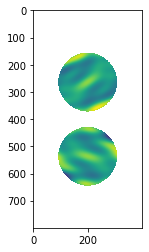

In [51]:
plt.figure()
#plt.imshow(img_xds.IMAGE.isel(chan=chan,time=0,pol=0))
plt.imshow(mosaic_img[:, :, 0, 0])

### Calculate Pixel Position

In [44]:
phase_center = grid_parms['phase_center']
w = WCS(naxis=2)
w.wcs.crpix = np.array(grid_parms['image_size'])//2
w.wcs.cdelt = np.array([-20,20])*arcsec_to_deg
w.wcs.crval = phase_center*rad_to_deg
w.wcs.ctype = ['RA---SIN','DEC--SIN']

In [45]:
lm_pix_pos = w.all_world2pix(point_source_ra_dec[0,:,:]*rad_to_deg, 1)
print('source pix pos',lm_pix_pos)

source pix pos [[365.90135428 200.048544  ]]


In [83]:
lm_pix_pos = w.all_world2pix(pointing_ra_dec[0,:,:]*rad_to_deg, 1)
print('source pix pos',lm_pix_pos)

source pix pos [[ 65.90135428 200.048544  ]
 [134.268903   140.04912485]]


In [42]:
cell_size = np.array(grid_parms['cell_size'])*arcsec_to_rad
cell_size[0] = -cell_size[0]
image_center = np.array(grid_parms['image_size'])//2
source_lm_pos = lm_pix_pos*cell_size - image_center*cell_size
print('source lm pos',source_lm_pos)

source lm pos [[-0.00156774  0.00203728]]


### Plot Primary Beam

In [4]:
from sirius._sirius_utils._make_pb_symmetric import _casa_airy_disk

In [58]:
grid_parms = {}
grid_parms['chan_mode'] = 'continuum'
grid_parms['image_size'] = np.array([200,400])
grid_parms['cell_size'] = np.array([-20,20])*arcsec_to_rad
grid_parms['phase_center'] = pointing_ra_dec[0,0,:]
pol = [1]
grid_parms['image_center'] = grid_parms['image_size']//2

grid_parms2 = {}
grid_parms2['chan_mode'] = 'continuum'
grid_parms2['image_size'] = np.array([200,400])
grid_parms2['cell_size'] = np.array([-20,20])*arcsec_to_rad
grid_parms2['phase_center'] = pointing_ra_dec2[0,0,:]
pol = [1]
grid_parms2['image_center'] = grid_parms['image_size']//2

In [59]:
pb_parms = {}
pb_parms['pb_func'] = 'casa_airy'
pb_parms['list_dish_diameters'] = [24.5] #Can make this smaller for larger primary beam
pb_parms['list_blockage_diameters'] = [0.0]
pb_parms['ipower'] = 2
pb_parms['pb_limit'] = 0.2

In [60]:
pointing_ra_dec[0, :, :]

array([[5.23369701, 0.71093805],
       [4.95008101, 0.70512029]])

In [61]:
pointing_ra_dec2

array([[[4.95008101, 0.70512029]]])

In [62]:
pb = _casa_airy_disk(freq_chan,pol,pb_parms,grid_parms)
pb2 = _casa_airy_disk(freq_chan,pol,pb_parms,grid_parms2)

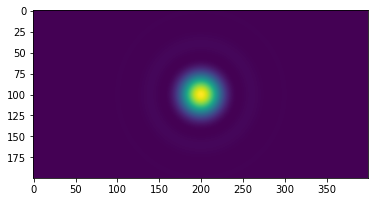

In [63]:
plt.figure()
plt.imshow(pb[:,:,1,0,0])
#plt.imshow(pb2[:,:,1,0,0])

plt.show()